In [1]:
from prosit_t.inference.inference_time import get_model_times, plot_inference_time_comparison
import tensorflow as tf
import os
import wandb
from prosit_t.wandb_agent.train_utils import get_proteometools_data
from prosit_t.models import PrositTransformerV2, PrositTransformerDynamicLenDropLast
from prosit_t.eval import prosit_transformer_eval
from dlomix.models import PrositIntensityPredictor
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd

2023-12-10 18:10:25.418343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 18:10:25.601303: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 18:10:28.048956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-10 18:10:28.049151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
data_config = {
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/first_pool_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/first_pool_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [4]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [5]:
_, val_data = get_proteometools_data(data_config)

2023-12-10 18:12:07.537627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 18:12:07.737342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


In [28]:
test_batch = val_data.take(1).cache()

In [7]:
artifact_path = "prosit-compms/transforming-prosit-first-pool/model-hardy-pine-74:v144"
transformer = PrositTransformerV2(
    seq_length=30,
    embedding_output_dim=64,
    num_heads=16,
    num_transformers=6,
    dense_dim_factor=4
)
transformer = prosit_transformer_eval.load_model(run,artifact_path,transformer)

wandb:   5 of 5 files downloaded.  
2023-12-10 18:12:34.447296: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-hardy-pine-74:v144: FAILED_PRECONDITION: artifacts/model-hardy-pine-74:v144; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [8]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-classic-star-15:v45"
baseline = PrositIntensityPredictor(
    seq_length=30,
    embedding_output_dim=16,
    recurrent_layers_sizes=(256, 512)
)
baseline = prosit_transformer_eval.load_model(run,baseline_path,baseline)

wandb:   4 of 4 files downloaded.  
2023-12-10 18:12:35.633853: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-classic-star-15:v45: FAILED_PRECONDITION: artifacts/model-classic-star-15:v45; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [9]:
artifact_small_path = "prosit-compms/transforming-prosit-first-pool/model-swept-monkey-124:v80"
transformer_small = PrositTransformerV2(
    seq_length=30,
    embedding_output_dim=64,
    num_heads=8,
    num_transformers=6,
    dense_dim_factor=4
)
transformer_small = prosit_transformer_eval.load_model(run,artifact_small_path,transformer_small)

wandb:   5 of 5 files downloaded.  
2023-12-10 18:12:36.777244: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-swept-monkey-124:v80: FAILED_PRECONDITION: artifacts/model-swept-monkey-124:v80; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [10]:
full_dataset_artifact_path = "prosit-compms/transforming-prosit-full-dataset/model-sweet-vortex-24:v29"
full_dataset_transformer = PrositTransformerV2(seq_length=30,embedding_output_dim=64,num_heads=16,
        num_transformers=8, dense_dim_factor=8)
full_dataset_transformer = prosit_transformer_eval.load_model(run,full_dataset_artifact_path,full_dataset_transformer)

wandb:   4 of 4 files downloaded.  
2023-12-10 18:12:37.905294: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-sweet-vortex-24:v29: FAILED_PRECONDITION: artifacts/model-sweet-vortex-24:v29; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [29]:
df = get_model_times({
    "Transformer Prosit": transformer,
    "Prosit": baseline,
#     "Transformer Prosit Small": transformer_small,
    "Transformer Prosit (Full Dataset)": full_dataset_transformer
}, test_batch)

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.


array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726, ..., -0.26178533,
        -0.9223926 , -0.02718271],
       [ 0.49820426, -0.2426727 , -0.282421  , ..., -0.7721712 ,
        -0.93673563,  0.63827467]], dtype=float32)>, <tf.Tensor: shape=(1024, 512), dtype=float32, numpy=
array([[ 0.23185985,  0.16968769,  0.245864  , ..., -0.2800935 ,
         0.03575531,  0.21264188],
       [-0.3815385 ,  0.13353133, -0.35927722, ..., -0.32730782,
         0.04907574, -0.5091441 ],
       [ 0.22538973,  0.18395433,  0.24071917, ..., -0.29380304,
         0.02697334,  0.21208195],
       ...,
     

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"model": name, "time": inference_time}, ignore_index=True)


array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726, ..., -0.26178533,
        -0.9223926 , -0.02718271],
       [ 0.49820426, -0.2426727 , -0.282421  , ..., -0.7721712 ,
        -0.93673563,  0.63827467]], dtype=float32)>, <tf.Tensor: shape=(1024, 512), dtype=float32, numpy=
array([[ 0.23185985,  0.16968769,  0.245864  , ..., -0.2800935 ,
         0.03575531,  0.21264188],
       [-0.3815385 ,  0.13353133, -0.35927722, ..., -0.32730782,
         0.04907574, -0.5091441 ],
       [ 0.22538973,  0.18395433,  0.24071917, ..., -0.29380304,
         0.02697334,  0.21208195],
       ...,
     

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 35ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 35ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 31ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 31ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 30ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 30ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 41ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 32ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 36ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 31ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 31ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 32ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 31ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 39ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 39ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 32ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 28ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

1/1 [==============================] - 0s 29ms/step
array([[0.21534173],
       [0.21220897],
       [0.24663639],
       ...,
       [0.32626745],
       [0.21299644],
       [0.24857906]], dtype=float32)>, <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>]. Consider rewriting this model with the Functional API.
array([[-0.12475647, -0.11185224, -0.36816305, ..., -0.4405368 ,
        -0.8733714 , -0.15743761],
       [-0.22639813,  0.31281796, -0.14706308, ...,  0.23195663,
        -0.65345603, -0.12115816],
       [-0.16182186, -0.14555946,  0.00158684, ..., -0.04295483,
        -0.9256904 , -0.07038731],
       ...,
       [ 0.00658562,  0.15297432,  0.34812802, ...,  0.29844037,
        -0.8916168 , -0.20409799],
       [ 0.33158675,  0.2541514 ,  0.01709726

/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"model": name, "time": inference_time}, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"model": name, "time": inference_time}, ignore_index=True)


In [30]:
df["color"] = ["#2c77b4", "#f77f10", "#238523"]

/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


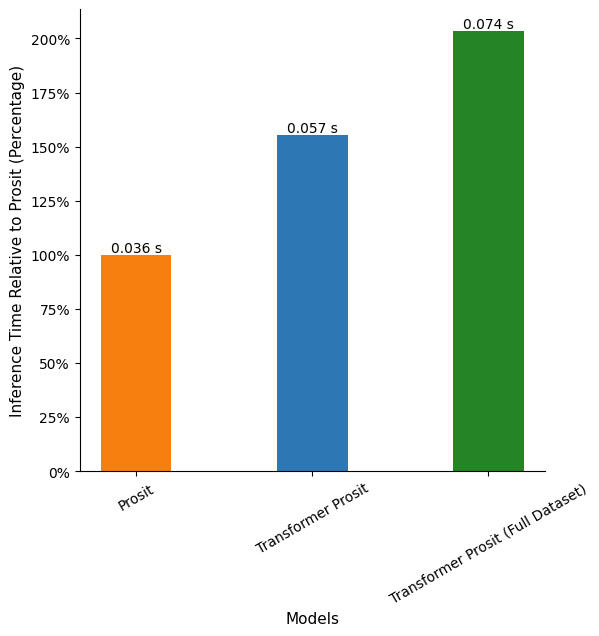

In [31]:
plot_inference_time_comparison(df, "Prosit")

In [14]:
from prosit_t.data.parquet_to_tfdataset import get_tfdatasets
_, val_data_dynamic = get_tfdatasets(data_config)

In [15]:
from prosit_t.constants import ALPHABET_UNMOD
artifact_dynamic_path = "prosit-compms/transforming-prosit-first-pool/model-skilled-moon-891:v99"
transformer_dynamic = PrositTransformerDynamicLenDropLast(
    embedding_output_dim=64,
    num_heads=16,
    meta_embedding_dim=256,
    num_transformers=6,
    vocab_dict=ALPHABET_UNMOD
)
transformer_dynamic = prosit_transformer_eval.load_model(run,artifact_dynamic_path,transformer_dynamic)

wandb:   5 of 5 files downloaded.  
2023-12-10 18:19:57.141710: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-skilled-moon-891:v99: FAILED_PRECONDITION: artifacts/model-skilled-moon-891:v99; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [16]:
full_dataset_artifact_dynamic_path = "prosit-compms/transforming-prosit-full-dataset/model-absurd-dawn-46:v17"
full_dataset_transformer_dynamic = PrositTransformerDynamicLenDropLast(
    embedding_output_dim=64,
    num_heads=16,
    meta_embedding_dim=512,
    num_transformers=8,
    vocab_dict=ALPHABET_UNMOD
)
full_dataset_transformer_dynamic = prosit_transformer_eval.load_model(
    run,
    full_dataset_artifact_dynamic_path,
    full_dataset_transformer_dynamic
)

wandb:   4 of 4 files downloaded.  
2023-12-10 18:19:59.095226: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-absurd-dawn-46:v17: FAILED_PRECONDITION: artifacts/model-absurd-dawn-46:v17; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [20]:
tf.config.run_functions_eagerly(True)

In [21]:
val_data_dynamic_skipped = val_data_dynamic.skip(7)
dynamic_test_batch = val_data_dynamic_skipped.take(1).cache()

In [36]:
dynamic_df = get_model_times({
    "Dynamic Transformer Prosit": transformer_dynamic,
    "Dynamic Transformer Prosit (Full Dataset)": full_dataset_transformer_dynamic,
}, dynamic_test_batch)

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 72ms/step


/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"model": name, "time": inference_time}, ignore_index=True)


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 73ms/step


/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"model": name, "time": inference_time}, ignore_index=True)


In [37]:
dynamic_df["color"] = ["#e7647a", "#b42c56"]

In [38]:
df_all = pd.concat([df, dynamic_df])

In [39]:
df_all["model"] = df_all["model"].apply(lambda x: x.replace(" ", "\n"))

/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


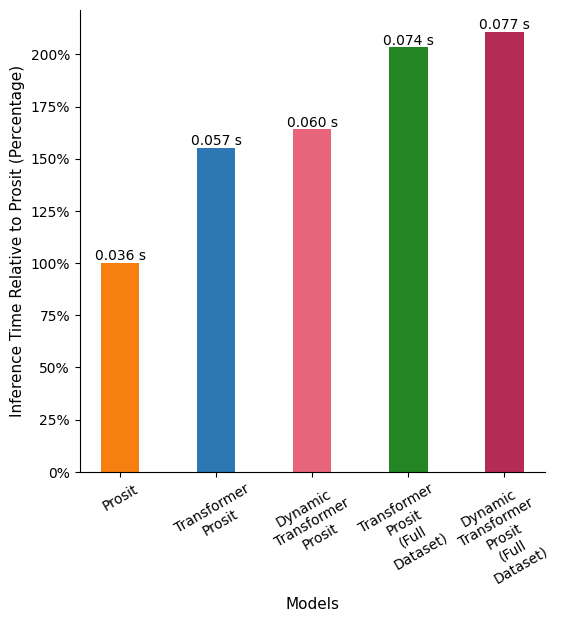

In [41]:
plot_inference_time_comparison(df_all, "Prosit")

/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


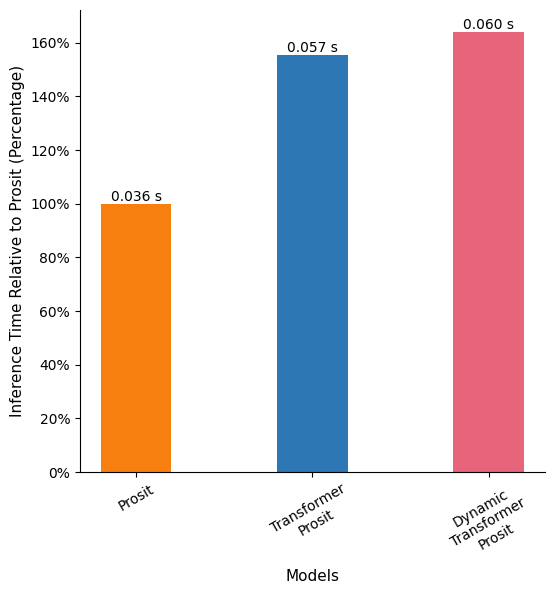

In [50]:
plot_inference_time_comparison(df_all[~df_all.model.str.contains("Full", regex=False)], "Prosit")